In [1]:
pip install --upgrade mne packaging

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.11.1 requires packaging<24, but you have packaging 24.1 which is incompatible.
rapids-dask-dependency 23.12.1 requires dask==2023.11.0, but you have dask 2023.3.2 which is incompatible.
rapids-dask-dependency 23.12.1 requires distributed==2023.11.0, but you have distributed 2023.3.2.1 which is incompatible.
tensorflow-addons 0.22.0 requires typeguard<3.0.0,>=2.7, but you have typeguard 4.1.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# %%
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE

import models  # Ensure models.py is in the same directory
from Physionet_DataLoad import load_physionet  # Ensure Physionet_DataLoad.py is in the same directory

In [10]:
# %%
def draw_learning_curves(history, results_path):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.savefig(results_path + '/ACC_' + '.png')
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.savefig(results_path + '/LOSS_' + '.png')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, results_path):
    display_labels = ['Both feet', 'Left fist', 'Both fists', 'Right fist']
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix')
    plt.savefig(results_path + '/subject_' + '.png')
    plt.show()

In [11]:
# %%
def train(dataset_conf, train_conf, results_path):
    in_exp = time.time()
    best_models = open(results_path + "/best_models.txt", "w")
    log_write = open(results_path + "/log.txt", "w")
    perf_allRuns = open(results_path + "/perf_allRuns.npz", 'wb')

    data_path = dataset_conf.get('data_path')
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves')
    model_name = train_conf.get('model')

    print('Training model: ', model_name)

    X_train, y_train_onehot, X_test, y_test_onehot = load_physionet(data_path)
    in_run = time.time()
    filepath = results_path + '/saved_models/run-1'
    os.makedirs(filepath, exist_ok=True)
    filepath = filepath + '/subject-1.h5'

    model = getModel(model_name)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    callbacks = [
        ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=patience)
    ]
    history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

    model.load_weights(filepath)
    y_pred = model.predict(X_test).argmax(axis=-1)
    labels = y_test_onehot.argmax(axis=-1)
    acc = accuracy_score(labels, y_pred)
    kappa = cohen_kappa_score(labels, y_pred)

    out_run = time.time()
    info = f'Subject: 1   Train no. 1   Time: {(out_run - in_run) / 60:.3f} m   Test_acc: {acc:.5f}   Test_kappa: {kappa:.5f}'
    print(info)
    log_write.write(info + '\n')

    best_run = np.argmax([acc])
    best_models.write(f'/saved_models/run-{best_run + 1}/subject-1.h5\n')
    out_sub = time.time()
    info = f'Subject: 1   best_run: {best_run + 1}   Time: {(out_sub - in_run) / 60:.3f} m   acc: {acc:.5f}'
    print(info)
    log_write.write(info + '\n')

    if LearnCurves:
        draw_learning_curves(history, results_path)

    np.savez(perf_allRuns, acc=acc, kappa=kappa)
    best_models.close()
    log_write.close()
    perf_allRuns.close()

    model = getModel(model_name)
    test(model, dataset_conf, results_path, X_test, y_test_onehot)

In [12]:
# %%
def test(model, dataset_conf, results_path, X_test, y_test_onehot):
    log_write = open(results_path + "/log.txt", "a")
    best_models = open(results_path + "/best_models.txt", "r")
    n_classes = dataset_conf.get('n_classes')
    cf_matrix = np.zeros([n_classes, n_classes])

    perf_allRuns = open(results_path + "/perf_allRuns.npz", 'rb')
    perf_arrays = np.load(perf_allRuns)
    acc_allRuns = perf_arrays['acc']
    kappa_allRuns = perf_arrays['kappa']

    filepath = best_models.readline().strip()
    model.load_weights(results_path + filepath)

    y_pred = model.predict(X_test).argmax(axis=-1)
    labels = y_test_onehot.argmax(axis=-1)
    acc_bestRun = accuracy_score(labels, y_pred)
    kappa_bestRun = cohen_kappa_score(labels, y_pred)
    cf_matrix[:, :] = confusion_matrix(labels, y_pred, normalize='pred')
    draw_confusion_matrix(cf_matrix, results_path)

    info = f'Subject: 1   best_run: 1   acc: {acc_bestRun:.5f}   kappa: {kappa_bestRun:.5f}   avg_acc: {np.average(acc_allRuns):.5f} +- {acc_allRuns.std():.5f}'
    print(info)
    log_write.write('\n' + info)

    log_write.close()

In [13]:
# %%
def getModel(model_name):
    if model_name == 'DB_ATCNet':
        model = models.DB_ATCNet(
            n_classes=4,
            in_chans=64,
            in_samples=640,
            eegn_F1=16,
            eegn_D=2,
            eegn_kernelSize=64,
            eegn_poolSize=7,
            eegn_dropout=0.3,
            drop1=0.35,
            depth1=2,
            depth2=4,
            n_windows=5,
            attention='mha',
            tcn_depth=2,
            tcn_kernelSize=4,
            tcn_filters=32,
            tcn_dropout=0.3,
            drop2=0.1,
            drop3=0.15,
            drop4=0.15,
            tcn_activation='elu',
        )
    # Add other model cases here
    else:
        raise Exception(f"'{model_name}' model is not supported yet!")
    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1, 64, 640)]         0         []                            
                                                                                                  
 permute_4 (Permute)         (None, 640, 64, 1)           0         ['input_5[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 640, 64, 16)          1024      ['permute_4[0][0]']           
                                                                                                  
 batch_normalization_100 (B  (None, 640, 64, 16)          64        ['conv2d_12[0][0]']           
 atchNormalization)                                                                         

 add_84 (Add)                (None, 11, 1, 32)            0         ['dropout_181[0][0]',         
                                                                     'dropout_183[0][0]']         
                                                                                                  
 dropout_184 (Dropout)       (None, 11, 1, 32)            0         ['add_84[0][0]']              
                                                                                                  
 global_average_pooling2d_9  (None, 32)                   0         ['dropout_184[0][0]']         
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 reshape_18 (Reshape)        (None, 32, 1)                0         ['global_average_pooling2d_9[0
                                                                    ][0]']                        
          

                                                                                                  
 dropout_201 (Dropout)       (None, 7, 32)                0         ['multi_head_attention_22[0][0
                                                                    ]']                           
                                                                                                  
 dropout_209 (Dropout)       (None, 7, 32)                0         ['multi_head_attention_23[0][0
                                                                    ]']                           
                                                                                                  
 dropout_217 (Dropout)       (None, 7, 32)                0         ['multi_head_attention_24[0][0
                                                                    ]']                           
                                                                                                  
 add_85 (A

                                                                                                  
 conv1d_99 (Conv1D)          (None, 7, 32)                4128      ['dropout_202[0][0]']         
                                                                                                  
 conv1d_103 (Conv1D)         (None, 7, 32)                4128      ['dropout_210[0][0]']         
                                                                                                  
 conv1d_107 (Conv1D)         (None, 7, 32)                4128      ['dropout_218[0][0]']         
                                                                                                  
 batch_normalization_106 (B  (None, 7, 32)                128       ['conv1d_91[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

                                                                                                  
 activation_166 (Activation  (None, 7, 32)                0         ['add_102[0][0]']             
 )                                                                                                
                                                                                                  
 conv1d_92 (Conv1D)          (None, 7, 32)                4128      ['activation_142[0][0]']      
                                                                                                  
 conv1d_96 (Conv1D)          (None, 7, 32)                4128      ['activation_148[0][0]']      
                                                                                                  
 conv1d_100 (Conv1D)         (None, 7, 32)                4128      ['activation_154[0][0]']      
                                                                                                  
 conv1d_10

 conv1d_101 (Conv1D)         (None, 7, 32)                4128      ['add_95[0][0]']              
                                                                                                  
 conv1d_105 (Conv1D)         (None, 7, 32)                4128      ['add_99[0][0]']              
                                                                                                  
 conv1d_109 (Conv1D)         (None, 7, 32)                4128      ['add_103[0][0]']             
                                                                                                  
 batch_normalization_108 (B  (None, 7, 32)                128       ['conv1d_93[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_112 (B  (None, 7, 32)                128       ['conv1d_97[0][0]']           
 atchNorma

 activation_169 (Activation  (None, 7, 32)                0         ['add_104[0][0]']             
 )                                                                                                
                                                                                                  
 lambda_25 (Lambda)          (None, 32)                   0         ['activation_145[0][0]']      
                                                                                                  
 lambda_26 (Lambda)          (None, 32)                   0         ['activation_151[0][0]']      
                                                                                                  
 lambda_27 (Lambda)          (None, 32)                   0         ['activation_157[0][0]']      
                                                                                                  
 lambda_28 (Lambda)          (None, 32)                   0         ['activation_163[0][0]']      
          

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S011/S011R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S011/S011R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S011/S011R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S015/S015R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S015/S015R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S015/S015R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S019/S019R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S019/S019R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S019/S019R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S023/S023R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S023/S023R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S023/S023R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S027/S027R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S027/S027R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S027/S027R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S031/S031R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S031/S031R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S031/S031R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S035/S035R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S035/S035R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S035/S035R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S040/S040R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S040/S040R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S040/S040R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S044/S044R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S044/S044R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S044/S044R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S048/S048R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S048/S048R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S048/S048R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S052/S052R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S052/S052R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S052/S052R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S056/S056R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S056/S056R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S056/S056R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S060/S060R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S060/S060R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S064/S064R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S064/S064R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S064/S064R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S068/S068R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S068/S068R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S072/S072R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S072/S072R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S072/S072R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S076/S076R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S076/S076R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S076/S076R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S080/S080R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S080/S080R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S080/S080R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S084/S084R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S084/S084R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S084/S084R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S090/S090R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S090/S090R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S090/S090R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S095/S095R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S095/S095R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
1 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S099/S099R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S099/S099R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S099/S099R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S105/S105R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S105/S105R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S105/S105R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S109/S109R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S109/S109R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/work/HCOH/motors/eeg_motor_files/S109/S109R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['F', 'L', 'LR', 'R']
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 641 original time points ...
0 bad epochs dropped
['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 

2024-10-08 07:49:04.579304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_225/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 34s 53ms/step - loss: 1.2967 - accuracy: 0.3913 - val_loss: 1.1539 - val_accuracy: 0.4995
Epoch 2/500
260/260 [==============================] - 13s 49ms/step - loss: 1.1399 - accuracy: 0.5112 - val_loss: 1.0423 - val_accuracy: 0.5568
Epoch 3/500
260/260 [==============================] - 13s 48ms/step - loss: 1.0796 - accuracy: 0.5452 - val_loss: 0.9971 - val_accuracy: 0.5741
Epoch 4/500
260/260 [==============================] - 13s 49ms/step - loss: 1.0518 - accuracy: 0.5611 - val_loss: 0.9738 - val_accuracy: 0.5795
Epoch 5/500
260/260 [==============================] - 13s 49ms/step - loss: 1.0267 - accuracy: 0.5747 - val_loss: 0.9566 - val_accuracy: 0.6076
Epoch 6/500
260/260 [==============================] - 13s 49ms/step - loss: 1.0064 - accuracy: 0.5837 - val_loss: 0.9525 - val_accuracy: 0.6011
Epoch 7/500
260/260 [==============================] - 13s 49ms/step - loss: 0.9911 - accuracy: 0.5937 - val_loss: 0.9391 - val_accuracy: 0.61

260/260 [==============================] - 13s 49ms/step - loss: 0.6919 - accuracy: 0.7296 - val_loss: 0.9017 - val_accuracy: 0.6595
Epoch 114/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6897 - accuracy: 0.7322 - val_loss: 0.9222 - val_accuracy: 0.6519
Epoch 115/500
260/260 [==============================] - 13s 49ms/step - loss: 0.7014 - accuracy: 0.7263 - val_loss: 0.9579 - val_accuracy: 0.6357
Epoch 116/500
260/260 [==============================] - 13s 50ms/step - loss: 0.6740 - accuracy: 0.7403 - val_loss: 0.9652 - val_accuracy: 0.6368
Epoch 117/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6897 - accuracy: 0.7350 - val_loss: 0.9312 - val_accuracy: 0.6519
Epoch 118/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6809 - accuracy: 0.7376 - val_loss: 0.9258 - val_accuracy: 0.6584
Epoch 119/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6858 - accuracy: 0.7385 - val_loss: 0.9286 - val_ac

Epoch 169/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6280 - accuracy: 0.7603 - val_loss: 0.9618 - val_accuracy: 0.6486
Epoch 170/500
260/260 [==============================] - 13s 48ms/step - loss: 0.6386 - accuracy: 0.7498 - val_loss: 0.9218 - val_accuracy: 0.6584
Epoch 171/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6338 - accuracy: 0.7540 - val_loss: 0.9478 - val_accuracy: 0.6465
Epoch 172/500
260/260 [==============================] - 13s 48ms/step - loss: 0.6216 - accuracy: 0.7531 - val_loss: 0.9596 - val_accuracy: 0.6573
Epoch 173/500
260/260 [==============================] - 13s 48ms/step - loss: 0.6322 - accuracy: 0.7588 - val_loss: 0.9450 - val_accuracy: 0.6530
Epoch 174/500
260/260 [==============================] - 13s 49ms/step - loss: 0.6416 - accuracy: 0.7502 - val_loss: 0.9331 - val_accuracy: 0.6595
Epoch 175/500
260/260 [==============================] - 13s 48ms/step - loss: 0.6402 - accuracy: 0.7547 - val_loss: 0

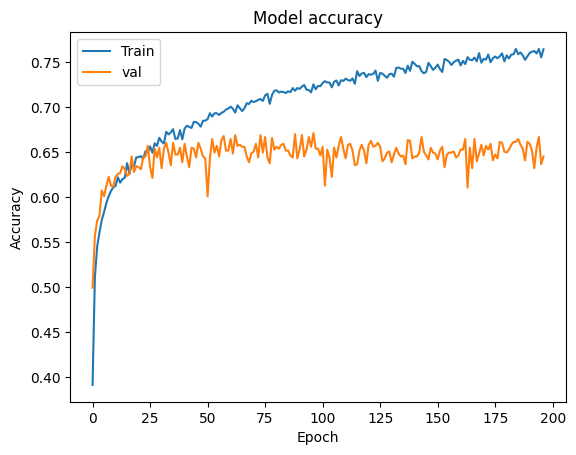

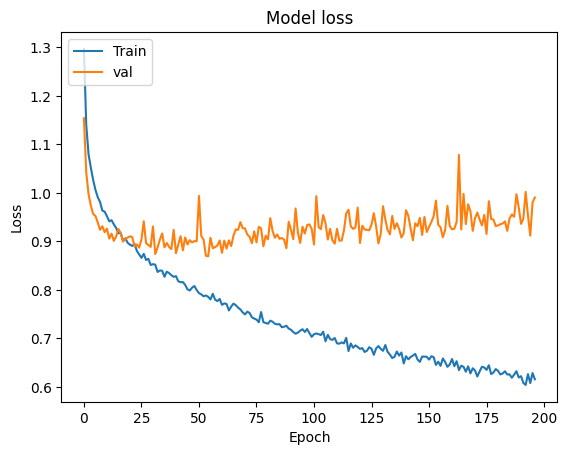


Time: 0.720 h
29/29 [==============================] - 0s 8ms/step


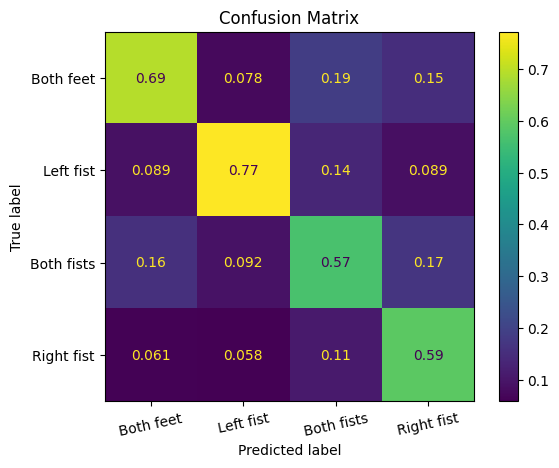

Subject: 1   best_run: 1  acc: 0.64541   kappa: 0.52728


In [18]:
# %% 필요한 라이브러리 가져오기
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.manifold import TSNE

import models
from Physionet_DataLoad import load_physionet


# %% 학습 곡선 그리기 함수
def draw_learning_curves(history, results_path):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.savefig(os.path.join(results_path, 'ACC.png'))
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.savefig(os.path.join(results_path, 'LOSS.png'))
    plt.show()
    plt.close()


# %% 혼동 행렬 그리기 함수
def draw_confusion_matrix(cf_matrix, results_path):
    display_labels = ['Both feet', 'Left fist', 'Both fists', 'Right fist']
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(results_path, 'subject.png'))
    plt.show()


# %% 학습 함수
def train(dataset_conf, train_conf, results_path):
    in_exp = time.time()
    os.makedirs(results_path, exist_ok=True)
    log_write = open(os.path.join(results_path, "log.txt"), "w")

    data_path = dataset_conf.get('data_path')
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves')
    model_name = train_conf.get('model')

    print('Training model: ', model_name)

    in_sub = time.time()
    BestSubjAcc = 0
    bestTrainingHistory = []
    X_train, y_train_onehot, X_test, y_test_onehot = load_physionet(data_path)

    in_run = time.time()

    model = getModel(model_name)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=patience)
    ]
    history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1)

    y_pred = model.predict(X_test).argmax(axis=-1)
    labels = y_test_onehot.argmax(axis=-1)
    acc = accuracy_score(labels, y_pred)
    kappa = cohen_kappa_score(labels, y_pred)

    out_run = time.time()
    info = f'Subject: 1   Train no. 1   Time: {(out_run - in_run) / 60:.3f} m   Test_acc: {acc:.5f}   Test_kappa: {kappa:.5f}'
    print(info)
    log_write.write(info + '\n')

    if BestSubjAcc < acc:
        BestSubjAcc = acc
        bestTrainingHistory = history

    out_sub = time.time()
    info = f'----------\nSubject: 1   best_run: 1   Time: {(out_sub - in_sub) / 60:.3f} m   acc: {acc:.5f}   avg_acc: {acc:.5f}   kappa: {kappa:.5f}\n----------'
    print(info)
    log_write.write(info + '\n')

    if LearnCurves:
        draw_learning_curves(bestTrainingHistory, results_path)

    out_exp = time.time()
    info = f'\nTime: {(out_exp - in_exp) / (60 * 60):.3f} h'
    print(info)
    log_write.write(info + '\n')
    log_write.close()

    test(model, dataset_conf, results_path, X_test, y_test_onehot)


# %% 평가 함수
def test(model, dataset_conf, results_path, X_test, y_test_onehot):
    log_write = open(os.path.join(results_path, "log.txt"), "a")
    n_classes = dataset_conf.get('n_classes')

    cf_matrix = np.zeros([n_classes, n_classes])
    y_pred = model.predict(X_test).argmax(axis=-1)
    labels = y_test_onehot.argmax(axis=-1)
    acc_bestRun = accuracy_score(labels, y_pred)
    kappa_bestRun = cohen_kappa_score(labels, y_pred)
    cf_matrix[:, :] = confusion_matrix(labels, y_pred, normalize='pred')
    draw_confusion_matrix(cf_matrix, results_path)

    info = f'Subject: 1   best_run: 1  acc: {acc_bestRun:.5f}   kappa: {kappa_bestRun:.5f}'
    print(info)
    log_write.write('\n' + info)
    log_write.close()


# %% 모델 가져오기 함수
def getModel(model_name):
    if model_name == 'DB_ATCNet':
        model = models.DB_ATCNet(
            n_classes=4,
            in_chans=64,
            in_samples=640,
            eegn_F1=16,
            eegn_D=2,
            eegn_kernelSize=64,
            eegn_poolSize=7,
            eegn_dropout=0.3,
            drop1=0.35,
            depth1=2,
            depth2=4,
            n_windows=5,
            attention='mha',
            tcn_depth=2,
            tcn_kernelSize=4,
            tcn_filters=32,
            tcn_dropout=0.3,
            drop2=0.1,
            drop3=0.15,
            drop4=0.15,
            tcn_activation='elu',
        )
    else:
        raise Exception(f"'{model_name}' model is not supported yet!")
    return model


# %% 실행 함수
def run():
    data_path = "motors/eeg_motor_files"
    results_path = os.path.join(os.getcwd(), "results")
    os.makedirs(results_path, exist_ok=True)

    dataset_conf = {'n_classes': 4, 'n_channels': 64, 'data_path': data_path}
    train_conf = {'batch_size': 32, 'epochs': 500, 'patience': 100, 'lr': 0.0009, 'LearnCurves': True, 'model': 'DB_ATCNet'}

    model = getModel(train_conf.get('model'))
    model.summary()

    train(dataset_conf, train_conf, results_path)


# %% Jupyter 환경에서 실행
if __name__ == "__main__":
    run()